_Last updated on 03/27/2021_ 

__Need to update the mathematical formulations based on fixed bugs__

In [3]:
import gurobipy as gp
from gurobipy import GRB, max_, abs_
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import time
from graphviz import Digraph, Graph
%matplotlib inline

### Network Visualization

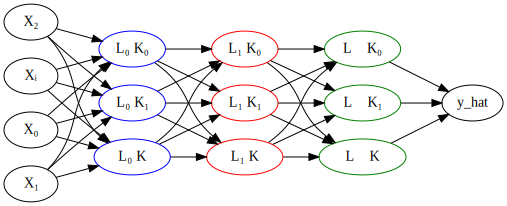

In [5]:
SUB = str.maketrans("0123456789imn", "₀₁₂₃₄₅₆₇₈₉ᵢₘₙ")

g = Digraph()
g = Digraph(graph_attr={'rankdir':'LR'})

g.node("L0 K0".translate(SUB), color="blue")
g.node("L0 K1".translate(SUB), color="blue")
g.node("L0 Kn".translate(SUB), color="blue")

g.node("L1 K0".translate(SUB), color="red")
g.node("L1 K1".translate(SUB), color="red")
g.node("L1 Kn".translate(SUB), color="red")

g.node("Lm K0".translate(SUB), color="green")
g.node("Lm K1".translate(SUB), color="green")
g.node("Lm Kn".translate(SUB), color="green")


g.edge("X0".translate(SUB), "L0 K0".translate(SUB))
g.edge("X0".translate(SUB), "L0 K1".translate(SUB))
g.edge("X0".translate(SUB), "L0 Kn".translate(SUB))
g.edge("X1".translate(SUB), "L0 K0".translate(SUB))
g.edge("X1".translate(SUB), "L0 K1".translate(SUB))
g.edge("X1".translate(SUB), "L0 Kn".translate(SUB))
g.edge("X2".translate(SUB), "L0 K0".translate(SUB))
g.edge("X2".translate(SUB), "L0 K1".translate(SUB))
g.edge("X2".translate(SUB), "L0 Kn".translate(SUB))
g.edge("Xi".translate(SUB), "L0 K0".translate(SUB))
g.edge("Xi".translate(SUB), "L0 K1".translate(SUB))
g.edge("Xi".translate(SUB), "L0 Kn".translate(SUB))

g.edge("L0 K0".translate(SUB), "L1 K0".translate(SUB))
g.edge("L0 K0".translate(SUB), "L1 K1".translate(SUB))
g.edge("L0 K0".translate(SUB), "L1 Kn".translate(SUB))

g.edge("L0 K1".translate(SUB), "L1 K0".translate(SUB))
g.edge("L0 K1".translate(SUB), "L1 K1".translate(SUB))
g.edge("L0 K1".translate(SUB), "L1 Kn".translate(SUB))

g.edge("L0 Kn".translate(SUB), "L1 K0".translate(SUB))
g.edge("L0 Kn".translate(SUB), "L1 K1".translate(SUB))
g.edge("L0 Kn".translate(SUB), "L1 Kn".translate(SUB))

g.edge("L1 K0".translate(SUB), "Lm K0".translate(SUB))
g.edge("L1 K0".translate(SUB), "Lm K1".translate(SUB))
g.edge("L1 K0".translate(SUB), "Lm Kn".translate(SUB))

g.edge("L1 K1".translate(SUB), "Lm K0".translate(SUB))
g.edge("L1 K1".translate(SUB), "Lm K1".translate(SUB))
g.edge("L1 K1".translate(SUB), "Lm Kn".translate(SUB))

g.edge("L1 Kn".translate(SUB), "Lm K0".translate(SUB))
g.edge("L1 Kn".translate(SUB), "Lm K1".translate(SUB))
g.edge("L1 Kn".translate(SUB), "Lm Kn".translate(SUB))

g.edge("Lm K0".translate(SUB), "y_hat".translate(SUB))
g.edge("Lm K1".translate(SUB), "y_hat".translate(SUB))
g.edge("Lm Kn".translate(SUB), "y_hat".translate(SUB))

g

### Notes on Layer-wise training

Using a MIP to optimize weights for each layer one by one
1. Layer Freezing
    * Optimize one layer MIP
    * Remove outermost layer
    * Freeze outputs of previous layers
    * Add new layer
    * Re-add outermost layer
    * Re-train on new layer
    
     **Notes on Layer Freezing:** 
    * Do we modify our MIP somehow or can we recursively call the one-layer MIP function L times?

    * What if we formulate a new MIP that only optimizes the weights of one layer corresponding to the expected input of the next layer? We use our 2 layer MIP used first. Then the weights determined of that need to be the "expected input" used in our second MIP (the weights of the layer in the second MIP need be optimized such that the output of this layer are the weights used in the first layer of our first MIP.
    
    * Isn't this still only pretraining? It looks like we still have to use our Multilayer NN MIP at the end. This means that we still face the issue of the algorithm taking too long to solve the problem for a large L. 
   
<br><br>
2. Layer-wise method as laid out in end-of-end-to-end
    * Takes an NN as input (randomized weights, randomized biases, layers, units, layer that is to be trained etc.)
    * Here, all weights except for the one that needs to be trained is a parameter (not a variable)
        * Probably as a dict
    * Trainable layer weights and bias, and output of each layer are weights
    * Train to minimize loss
    
    **Notes:**
    * Mutual Information?
    * Simultaneous training vs iterative training. Update weights with each iteration?


### Layer-wise MIP formulation

__General parameters for all layers:__

$ x_{n,d}: \textit{binary vector inputs of size n} \times \textit{d, where n is the number of data points, d is the number of dimensions/features/} $ 

$ y_{n}: \textit{ binary  vector labeled outputs of size n} \times \textit{1, where n is the number of data points} $

$ w\prime_{d,k}:\textit{randomized weights for feature d in unit k of the first hidden layer} $

$ w_{k\prime,k,l}:\textit{randomized weights from the} \;k\prime^{th}\; \textit{unit in the} \;(l-1)^{st}\; \textit{layer to the}\;k^{th}\;\textit{unit in the} \;l^{th}\; \textit{layer, } \forall\;k\prime,\;k \in K,\;l \in \{2,3,4,...,L-1\} $

$ w_{(output)k\prime}:\textit{randomized weights from the}\;k\prime^{th}\;\textit{unit in the}\;(L-1)^{st}\;\textit{layer to unit output layer L,}\forall\;k\prime \in K $

$ b_{k,l}:\textit{randomized bias in unit k of layer l, }\forall\;l \in\;{1,2,...,L-1} $

$ b_{(final)}:\textit{randomized bias in the final layer} $

__For the first layer__

__Decision Variables:__

$ \alpha\prime_{d,k}:\textit{Weight for feature d in unit k in the first hidden layer,}\forall\;d\in D,\;k \in K $

$ \beta_{k,1}: \textit{Bias for unit k in the first layer}\forall\;k \in K $

$ h_{n,k,l}: \textit{Binary output of unit k in layer l,} \forall\;n \in N, \;k \in K,\;l \in \{1,2,...L-1\} $

$ z_{n,k\prime,l}: \textit{Auxilliary variable, } \forall\;n \in N, \;k\prime,\;k \in K,\;l \in \{2,3,...,L\} $ 

$ \hat{y}\prime_{n}: \textit{Raw output of final layer,}\forall\;n \in N $

$ \hat{y}_{n}: \textit{Binary activated output of final layer,}\forall\;n \in N $

$ \ell\prime_{n}: \textit{Misclassification of data point n,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $

__Objective:__

$\displaystyle \min_{W,\beta,h,z,\hat{y}\prime,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \hat{y}\prime_{n} = (\displaystyle  \sum_{k\prime=1}^{K} z_{n,k\prime,L}) + b_{(final)}, \; \forall \; n,k $

$ \quad\quad\quad\quad\;\; \hat{y}_{n} = max(0,\hat{y}\prime_{n}), \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; \alpha\prime_{d,k}^{T}x_{n} + \beta_{k,1} \le 0 - \epsilon + (M+\epsilon)h_{n,k,1}, \; \forall \;n,k,d $

$ \quad\quad\quad\quad\;\; \alpha\prime_{d,k}^{T}x_{n} + \beta_{k,1} \ge \epsilon + (m-\epsilon)(1-h_{n,k,1}), \; \forall \; n,k,d $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l} \le 0 - \epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l}  \ge \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,l\in\;\{2,3,...,L-1\}$ 

$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \le M(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \ge m(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,l} \le h_{n,k,(l-1)}, \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\}$

$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - w_{(output)k} \le M(1-h_{n,k,(L-1)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - w_{(output)k} \ge m(1-h_{n,k,(L-1)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,L-1} \le h_{n,k,(L-2)}, \; \forall\;n,k,k\prime$

$ $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha\prime_{d,k}\;\le Upper\;Bound, \; \forall \; d,k,k\prime $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k,1} \le Upper\;Bound, \; \forall \; k $


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k,l}  \in \{0,1\}, \; \forall \; n,k,l\in\;\{1,2,...,L-1\}$


$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N$



In [4]:
def Module1Solver(data, output, randomized, num_layers, units, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1): 
    
    """
    This function trains the first layer in a neural network with given randomized weights and biases
    in a layer-wise fashion
    """
    
    # Extract information from NN (the randomized weights and biases)
    
    L = num_layers # number of layers
    K = units # number of units per layer
    N = output.shape[0] # number of units in the training set
    D = data[0].shape[0] # dimension of data
    epsilon = 0.0001

    x = data # binary feature matrix n x d
    y = output # labeled data n x 1
    
    # Given that the parameters of the NN are formated as the dictionary above
    # we only use w, w_output, b, and b_output for Module 1
    
    w = randomized["w"]
    w_output = randomized["w_output"]
    b = randomized["b"]
    b_output = randomized["b_output"]

    assert x.shape[0] >= y.shape[0] # assert the same number of columns for the input and output
                                    # each data point as at least one corresponding output
    
    # Create a model to train the first layer
    m1 = gp.Model("First Layer MIP") 
    
    # Create variables
    
    alpha_prime = {}
    beta_prime = {}
    h = {}
    z = {}
    y_hat_prime = {}
    y_hat = {}
    loss_prime = {}
    loss = {}

    for k in range(K):
        beta_prime[k] = m1.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta_prime"+str(k)) # bias for the first layer
        for d in range(D):
            alpha_prime[(d,k)] = m1.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha_prime"+str((d,k))) # weights for the first hidden layer
            
    for n in range(N):
#         y_hat_prime[n] = m1.addVar(lb = w_lb+b_lb, ub = w_ub+b_ub, vtype=GRB.CONTINUOUS, name="y_hat_prime"+str(n))
        y_hat[n] = m1.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss_prime[n] = m1.addVar(lb = -1, ub=1, vtype=GRB.CONTINUOUS, name="loss_prime"+str(n))
        loss[n] = m1.addVar(ub = 1, vtype=GRB.CONTINUOUS, name="loss"+str(n)) # loss
        
        for k in range(K):
            for l in range(0,L-1):
                h[(n,k,l)] = m1.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l))) # output of each _hidden_ layer
            for k_prime in range(K):
                for l in range(1, L-1):
                    z[(n,k_prime,k,l)] = m1.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,l))) # Auxilliary variable. Double check lower bound
                    
            z[(n,k,L-1)] = m1.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k,L-1))) # Auxilliary variable. Double check lower bound
            # actually (n,k\prime,l) but since it is also in K, it's alright to say (n,k,l)
    
    # Set objective
    m1.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        
#         m1.addConstr(y_hat_prime[n] == (sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + b_output), name="y_hat_prime"+str(n)+" definition")
#         m1.addConstr(y_hat[n] == max_(y_hat_prime[n],0), name="ReLU"+str(n))

        m1.addConstr(sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + b_output
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*y_hat[n], name="output_final1 "+str(n))

        m1.addConstr(sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + b_output
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-y_hat[n]), name="output_final2 "+str(n))

        
        m1.addConstr(loss_prime[n] == y[n] - y_hat[n], name="loss_prime"+str(n)+" definition") 
        m1.addConstr(loss[n] == abs_(loss_prime[n]), name="loss"+str(n)+" absolute")

        
    for n in range(N):
        for k in range(K):
            
            m1.addConstr(sum(alpha_prime[(d,k)]*x[n,d] for d in range(D)) + beta_prime[k] 
                        <= 0.0 - epsilon + (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="output_first_layer1 "+str((n,k))) # M is sum of upper-bounds
            
            m1.addConstr(sum(alpha_prime[(d,k)]*x[n,d] for d in range(D)) + beta_prime[k] 
                        >= 0.0 + epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="output_first_layer2 "+str((n,k))) # m is sum of lower-bounds

    for n in range(N):
        for k in range(K):
            for l in range(1, L-1):
                m1.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + b[(k,l)] 
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="output_general1 "+str((n,k,l))) # M is sum of upper-bounds

                m1.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + b[(k,l)] 
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="output_general2 "+str((n,k,l))) # m is sum of lower-bounds

    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L-1):
                    m1.addConstr(z[(n,k_prime,k,l)] <= w[(k_prime,k,l)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def1 "+str((n,k,k_prime,l))) 
                    m1.addConstr(z[(n,k_prime,k,l)] >= w[(k_prime,k,l)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def2 "+str((n,k,k_prime,l))) 
                    m1.addConstr(z[(n,k_prime,k,l)] <= (w_ub)*h[(n,k_prime,l-1)], name="auxilliar_bound1 "+str((n,k,k_prime,l)))
                    m1.addConstr(z[(n,k_prime,k,l)] >= (w_lb)*h[(n,k_prime,l-1)], name="auxilliar_bound2 "+str((n,k,k_prime,l)))                    
                
            m1.addConstr(z[(n,k_prime,L-1)] <= w_output[k_prime] + (w_ub-w_lb)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last1 "+str((n,k_prime,L))) 
            m1.addConstr(z[(n,k_prime,L-1)] >= w_output[k_prime] + (w_lb-w_ub)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last2 "+str((n,k_prime,L))) 
            m1.addConstr(z[(n,k_prime,L-1)] <= (w_ub)*h[(n,k_prime,L-2)], name="auxilliar_bound_last1 "+str((n,k_prime,L)))
            m1.addConstr(z[(n,k_prime,L-1)] >= (w_lb)*h[(n,k_prime,L-2)], name="auxilliar_bound_last2 "+str((n,k_prime,L)))
                    
                
    # Optimize model
    m1.setParam('OutputFlag', 0)
    m1.optimize()
    m1.printQuality()
    
    weights_dict = {}
    
    for k in range(K):
        weights_dict[m1.getVarByName("beta_prime"+str(k)).varName] = np.round(m1.getVarByName("beta_prime"+str(k)).x, 6)
        for d in range(D):
            weights_dict[m1.getVarByName("alpha_prime"+str((d,k))).varName] = np.round(m1.getVarByName("alpha_prime"+str((d,k))).x, 6)

#     for v in m1.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 6)))
    
    print('Obj: %g' % m1.objVal)
    
    return(m1.objVal, weights_dict)

----------------------------------------------------------------------------------------------------------------------

__For the middle hidden layers__ (loop over range(2,L-1))

__Decision Variables:__

$ \alpha_{k\prime,k,t}: \textit{Weight from the} \;k\prime^{th}\; \textit{unit in layer t-1  to unit k in the trainable layer t, }\forall\;k\prime,\;k \in K$

$ \beta_{k,t}: \textit{Bias for unit k in the trainable layer t, }\forall\;k \in K $

$ h_{n,k,l}: \textit{Binary output of unit k in layer l,} \forall\;n \in N, \;k \in K,\;l \in \{1,2,...L-1\} $

$ z_{n,k\prime,l}: \textit{Auxilliary variable, } \forall\;n \in N, \;k\prime,\;k \in K,\;l \in \{2,3,...,L\} $ 

$ \hat{y}\prime_{n}: \textit{Raw output of final layer,}\forall\;n \in N $

$ \hat{y}_{n}: \textit{Binary activated output of final layer,}\forall\;n \in N $

$ \ell\prime_{n}: \textit{Misclassification of data point n,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $


__Objective:__

$\displaystyle \min_{W,\beta,h,z,\hat{y}\prime,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \hat{y}\prime_{n} = (\displaystyle  \sum_{k\prime=1}^{K} z_{n,k\prime,L}) + b_{(final)}, \; \forall \; n,k $

$ \quad\quad\quad\quad\;\; \hat{y}_{n} = max(0,\hat{y}\prime_{n}), \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; w\prime_{d,k}^{T}x_{n} + b_{k,1} \le 0 - \epsilon + (M+\epsilon)h_{n,k,1}, \; \forall \;n,k,d $

$ \quad\quad\quad\quad\;\; w\prime_{d,k}^{T}x_{n} + b_{k,1} \ge \epsilon + (m-\epsilon)(1-h_{n,k,1}), \; \forall \; n,k,d $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,t}) + \beta_{k,t} \le 0 - \epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,t\;is\;the\;trainable\;layer $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,t}) + \beta_{k,t}  \ge \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,t\;is\;the\;trainable\;layer $ 

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l} \le 0 - \epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,l\in\;\{2,3,...,L-1\}-\{t\} $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l}  \ge \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,l\in\;\{2,3,...,L-1\}-\{t\} $ 


$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,t} - \alpha_{k\prime,k,t} \le M(1-h_{n,k,(t-1)}), \; \forall\;n,k,k\prime,t\;is\;the\;trainable\;layer $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,t} - \alpha_{k\prime,k,t} \ge m(1-h_{n,k,(t-1)}), \; \forall\;n,k,k\prime,t\;is\;the\;trainable\;layer $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,t} \le h_{n,k,(t-1)}, \; \forall\;n,k,k\prime,t\;is\;the\;trainable\;layer $

$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \le M(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\}-\{t\} $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \ge m(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\}-\{t\} $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,l} \le h_{n,k,(l-1)}, \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\}-\{t\}$

$ $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - w_{(output)k} \le M(1-h_{n,k,(L-1)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - w_{(output)k} \ge m(1-h_{n,k,(L-1)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,L} \le h_{n,k,(L-1)}, \; \forall\;n,k,k\prime$

$ $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le\;\alpha_{k\prime,k,t}\;\le Upper\;Bound, \; \forall \; d,k,k\prime,t\;is\;the\;trainable\;layer$

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{k,t} \le Upper\;Bound, \; \forall \; k,t\;is\;the\;trainable\;layer$


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k,l}  \in \{0,1\}, \; \forall \; n,k,l\in\;\{1,2,...,L-1\}$


$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N$



In [5]:
def Module2Solver(data, output, randomized, num_layers, units, layer_to_train, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1): 
    
    """
    This function trains a middle hidden layer in a neural network with given randomized weights and biases
    in a layer-wise fashion
    """
    
    # Extract information from NN (the randomized weights and biases)
    
    L = num_layers # number of layers
    K = units # number of units per layer
    N = output.shape[0] # number of units in the training set
    D = data[0].shape[0] # dimension of data
    t = layer_to_train # Layer to train in a specific iteration
    epsilon = 0.0001

    x = data # binary feature matrix n x d
    y = output # labeled data n x 1
    
    # Given that the parameters of the NN are formated as the dictionary above
    # we use all the information except the randomized values of the trainable layer
    
    w_prime = randomized["w_prime"]
    w = randomized["w"]
    w_output = randomized["w_output"]
    b = randomized["b"]
    b_output = randomized["b_output"]

    assert x.shape[0] >= y.shape[0] # assert the same number of columns for the input and output
                                    # each data point as at least one corresponding output
    
    assert 1 <= t <= L-1 # assert that this solver is only used for "middle" hidden layers
    
    # Create a model to train the first layer
    m2 = gp.Model("Middle Layer MIP") 
    
    # Create variables
    
    alpha = {}
    beta = {}
    h = {}
    z = {}
    y_hat_prime = {}
    y_hat = {}
    loss_prime = {}
    loss = {}

    for k in range(K):
        beta[(k,t)] = m2.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta"+str((k,t))) # bias for the trainable hidden layer
        for k_prime in range(K):
            alpha[(k_prime,k,t)] = m2.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha"+str((k_prime, k,t))) # weights for the trainable hidden layers
    
    for n in range(N):
#         y_hat_prime[n] = m2.addVar(lb = w_lb+b_lb, ub = w_ub+b_ub, vtype=GRB.CONTINUOUS, name="y_hat_prime"+str(n))
        y_hat[n] = m2.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss_prime[n] = m2.addVar(lb = -1, ub=1, vtype=GRB.CONTINUOUS, name="loss_prime"+str(n))
        loss[n] = m2.addVar(ub = 1, vtype=GRB.CONTINUOUS, name="loss"+str(n)) # loss
        
        for k in range(K):
            for l in range(0,L-1):
                h[(n,k,l)] = m2.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l))) # output of each _hidden_ layer
            for k_prime in range(K):
                for l in range(1, L-1):
                    z[(n,k_prime,k,l)] = m2.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,l))) # Auxilliary variable. Double check lower bound
                    
            z[(n,k,L-1)] = m2.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k,L-1))) # Auxilliary variable. Double check lower bound
            # actually (n,k\prime,l) but since it is also in K, it's alright to say (n,k,l)
  
    # Set objective
    m2.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        
        m2.addConstr(sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + b_output
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*y_hat[n], name="output_final1 "+str(n))

        m2.addConstr(sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + b_output
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-y_hat[n]), name="output_final2 "+str(n))

        m2.addConstr(loss_prime[n] == y[n] - y_hat[n], name="loss_prime"+str(n)+" definition") 
        m2.addConstr(loss[n] == abs_(loss_prime[n]), name="loss"+str(n)+" absolute")

        
    for n in range(N):
        for k in range(K):
            
            output_0th = sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
            if output_0th > 0:
                h[(n,k,0)] = 1
            else:
                h[(n,k,0)] = 0
            
#             m2.addConstr(sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
#                          <= 0.0 - epsilon + (D*w_ub+b_ub + epsilon)*h[(n,k,0)], name="output_first_layer1 "+str((n,k))) # M is sum of upper-bounds
            
#             m2.addConstr(sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
#                          >= 0.0 + epsilon + (D*w_lb+b_lb - epsilon)*(1-h[(n,k,0)]), name="output_first_layer2 "+str((n,k))) # m is sum of lower-bounds

            # The above two commented out constraints gave the following error: GurobiError: Constraint has no bool value (are you trying "lb <= expr <= ub"?)

    for n in range(N):
        for k in range(K):
            m2.addConstr(sum(z[(n,k_prime,k,t)] for k_prime in range(K)) + beta[(k,t)] 
                        <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,t)], name="output_trainable1 "+str((n,k,t))) # M is sum of upper-bounds

            m2.addConstr(sum(z[(n,k_prime,k,t)] for k_prime in range(K)) + beta[(k,t)] 
                        >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,t)]), name="output_trainable2 "+str((n,k,t))) # m is sum of lower-bounds

    for n in range(N):
        for k in range(K):
            for l in range(1, L-1):
                if l == t:
                    continue # exclude the trainable layer from the randomized weight constraints
                    
                m2.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + b[(k,l)] 
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="output_general1 "+str((n,k,l))) # M is sum of upper-bounds

                m2.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + b[(k,l)] 
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="output_general2 "+str((n,k,l))) # m is sum of lower-bounds

    
    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                m2.addConstr(z[(n,k_prime,k,t)] <= alpha[(k_prime,k,t)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,t-1)]), name="auxilliary_def_trainable1 "+str((n,k,k_prime,t))) 
                m2.addConstr(z[(n,k_prime,k,t)] >= alpha[(k_prime,k,t)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,t-1)]), name="auxilliary_def_trainable2 "+str((n,k,k_prime,t))) 
                m2.addConstr(z[(n,k_prime,k,t)] <= (w_ub)*h[(n,k_prime,t-1)], name="auxilliary_bound_trainable1 "+str((n,k,k_prime,t)))
                m2.addConstr(z[(n,k_prime,k,t)] >= (w_lb)*h[(n,k_prime,t-1)], name="auxilliary_bound_trainable2 "+str((n,k,k_prime,t)))
                
                
    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L-1):
                    if l == t:
                        continue
                        
                    m2.addConstr(z[(n,k_prime,k,l)] <= w[(k_prime,k,l)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def1 "+str((n,k,k_prime,l))) 
                    m2.addConstr(z[(n,k_prime,k,l)] >= w[(k_prime,k,l)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def2 "+str((n,k,k_prime,l))) 
                    m2.addConstr(z[(n,k_prime,k,l)] <= (w_ub)*h[(n,k_prime,l-1)], name="auxilliary_bound1 "+str((n,k,k_prime,l)))
                    m2.addConstr(z[(n,k_prime,k,l)] >= (w_lb)*h[(n,k_prime,l-1)], name="auxilliary_bound2 "+str((n,k,k_prime,l)))
                
            m2.addConstr(z[(n,k_prime,L-1)] <= w_output[k_prime] + (w_ub-w_lb)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last1 "+str((n,k_prime,L))) 
            m2.addConstr(z[(n,k_prime,L-1)] >= w_output[k_prime] + (w_lb-w_ub)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last2 "+str((n,k_prime,L))) 
            m2.addConstr(z[(n,k_prime,L-1)] <= (w_ub)*h[(n,k_prime,L-2)], name="auxilliary_bound_last1 "+str((n,k_prime,L)))
            m2.addConstr(z[(n,k_prime,L-1)] >= (w_lb)*h[(n,k_prime,L-2)], name="auxilliary_bound_last2 "+str((n,k_prime,L)))
                                
    # Optimize model
    m2.setParam('OutputFlag', 0)
    m2.optimize()
    
    weights_dict = {}
    
    for k in range(K):
        weights_dict[m2.getVarByName("beta"+str((k,t))).varName] = np.round(m2.getVarByName("beta"+str((k,t))).x, 6)
        for k_prime in range(K):
            weights_dict[m2.getVarByName("alpha"+str((k_prime, k,t))).varName] = np.round(m2.getVarByName("alpha"+str((k_prime, k,t))).x, 6)

#     for v in m2.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 6)))
            
    print('Obj: %g' % m2.objVal)
    
    return(m2.objVal, weights_dict)

----------------------------------------------------------------------------------------------------------------------

__For the last (output) layer__

__Decision Variables:__

$ \alpha_{(output)k\prime}: \textit{Weight from the} \;k\prime^{th}\; \textit{unit in layer L-1  to the output layer, } \forall\;k\prime \in K$

$ \beta_{(output)}: \textit{Bias in the final layer } \textrm{Assuming the final layer has only one output, i.e, we have only one label. We would use} \; \beta_{m,L}\; \textrm{as the bias for the last layer in case we have m possible labels for each data point.} $

$ h_{n,k,l}: \textit{Binary output of unit k in layer l,} \forall\;n \in N, \;k \in K,\;l \in \{1,2,...L-1\} $

$ z_{n,k\prime,l}: \textit{Auxilliary variable, } \forall\;n \in N, \;k\prime,\;k \in K,\;l \in \{2,3,...,L\} $ 

$ \hat{y}\prime_{n}: \textit{Raw output of final layer,}\forall\;n \in N $

$ \hat{y}_{n}: \textit{Binary activated output of final layer,}\forall\;n \in N $

$ \ell\prime_{n}: \textit{Misclassification of data point n,}\forall\;n \in N $

$ \ell_{n}: \textit{Absolute Misclassification of data point n,}\forall\;n \in N $


__Objective:__

$\displaystyle \min_{W,\beta,h,z,\hat{y}\prime,\hat{y},\ell\prime,\ell} \; \displaystyle  \sum_{n=1}^{N} \ell_{n} $

__Constraints:__

subject to $\quad \hat{y}\prime_{n} = (\displaystyle  \sum_{k\prime=1}^{K} z_{n,k\prime,L}) + \beta_{(output)}, \; \forall \; n,k $

$ \quad\quad\quad\quad\;\; \hat{y}_{n} = max(0,\hat{y}\prime_{n}), \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell\prime_{n} = y_{n} - \hat{y}, \; \forall \; n \in N $

$ \quad\quad\quad\quad\;\; \ell_{n} = |\ell\prime_{n}|, \; \forall \; n \in N $


$ \quad\quad\quad\quad\;\; w\prime_{d,k}^{T}x_{n} + b_{k,1} \le 0 - \epsilon + (M+\epsilon)h_{n,k,1}, \; \forall \;n,k,d $

$ \quad\quad\quad\quad\;\; w\prime_{d,k}^{T}x_{n} + b_{k,1} \ge \epsilon + (m-\epsilon)(1-h_{n,k,1}), \; \forall \; n,k,d $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l} \le 0 - \epsilon + (M+\epsilon)h_{n,k,l}, \; \forall \;n,k,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\ \displaystyle  \sum_{k\prime=1}^{K} (z_{n,k\prime,l}) + b_{k,l}  \ge \epsilon + (m-\epsilon)(1-h_{n,k,l}), \; \forall \; n,k,l\in\;\{2,3,...,L-1\}$ 

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \le M(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,l} - w_{k\prime,k,l} \ge m(1-h_{n,k,(l-1)}), \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L-1\} $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,l} \le h_{n,k,(l-1)}, \; \forall\;n,k,k\prime,l\in\;\{2,3,...,L\}$

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - \alpha_{(output)k} \le M(1-h_{n,k,(L-2)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\; z_{n,k\prime,L} - \alpha_{(output)k} \ge m(1-h_{n,k,(L-2)}), \; \forall\;n,k,k\prime $

$ \quad\quad\quad\quad\;\;  0 \le z_{n,k\prime,L-1} \le h_{n,k,(L-1)}, \; \forall\;n,k,k\prime$


$ \quad\quad\quad\quad\;\; Lower\;Bound \le \alpha_{(output)k\prime}\;\le Upper\;Bound, \; \forall \; k\prime $

$ \quad\quad\quad\quad\;\; Lower\;Bound \le \beta_{(output)} \le Upper\;Bound $


$ \quad\quad\quad\quad\;\; \hat{y}_{n},\;h_{n,k,l}  \in \{0,1\}, \; \forall \; n,k,l\in\;\{1,2,...,L-1\}$


$ \quad\quad\quad\quad\;\; 0 \le \ell_{n} \le 1, \; \forall \; n \in N$



In [6]:
def Module3Solver(data, output, randomized, num_layers, units, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1): 
    
    """
    This function trains the last/output layer in a neural network with given randomized weights and biases
    in a layer-wise fashion
    """
    
    # Extract information from NN (the randomized weights and biases)
    
    L = num_layers # number of layers
    K = units # number of units per layer
    N = output.shape[0] # number of unit in the training set
#     N = 1
    D = data[0].shape[0] # dimension of data
    epsilon = 0.0001

    x = data # binary feature matrix n x d
    y = output # labeled data n x 1
    
    # Given that the parameters of the NN are formated as the dictionary above
    # we only use w', w, and b for Module 1
    
    w_prime = randomized["w_prime"]
    w = randomized["w"]
    b = randomized["b"]

    assert x.shape[0] >= y.shape[0] # assert the same number of columns for the input and output
                                    # each data point as at least one corresponding output
    
    # Create a model to train the first layer
    m3 = gp.Model("Final Layer MIP") 
    
    # Create variables
    
    alpha_output = {}
    beta_output = None
    h = {}
    z = {}
    y_hat_prime = {}
    y_hat = {}
    loss_prime = {}
    loss = {}

    for k in range(K):
        alpha_output[k] = m3.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name="alpha_output"+str(k)) # weights for the output layer
        # actually k\prime but since it is also in K, it's alright to say k
        
    beta_output = m3.addVar(lb=b_lb, ub=b_ub, vtype=GRB.CONTINUOUS, name="beta_output") # bias for the output layer
    
    for n in range(N):
#         y_hat_prime[n] = m3.addVar(lb = w_lb+b_lb, ub = w_ub+b_ub, vtype=GRB.CONTINUOUS, name="y_hat_prime"+str(n))
        y_hat[n] = m3.addVar(vtype=GRB.BINARY, name="y_hat"+str(n))
        loss_prime[n] = m3.addVar(lb = -1, ub=1, vtype=GRB.CONTINUOUS, name="loss_prime"+str(n))
        loss[n] = m3.addVar(ub = 1, vtype=GRB.CONTINUOUS, name="loss"+str(n)) # loss
        
        for k in range(K):
            for l in range(0,L-1):
                h[(n,k,l)] = m3.addVar(vtype=GRB.BINARY, name="h"+str((n,k,l))) # output of each _hidden_ layer
            for k_prime in range(K):
                for l in range(1, L-1):
                    z[(n,k_prime,k,l)] = m3.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k_prime,k,l))) # Auxilliary variable. Double check lower bound
                    
            z[(n,k,L-1)] = m3.addVar(lb=w_lb, ub=w_ub, vtype=GRB.CONTINUOUS, name= "z"+str((n,k,L-1))) # Auxilliary variable. Double check lower bound
            # actually (n,k\prime,l) but since it is also in K, it's alright to say (n,k,l)
    
    # Set objective
    m3.setObjective(sum(loss[n] for n in range(N)), GRB.MINIMIZE)
    
    # Add constraints
    
    for n in range(N):
        
        m3.addConstr(sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + beta_output
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*y_hat[n], name="output_final1 "+str(n))

        m3.addConstr(sum(z[(n,k_prime,L-1)] for k_prime in range(K)) + beta_output
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-y_hat[n]), name="output_final2 "+str(n))

        m3.addConstr(loss_prime[n] == y[n] - y_hat[n], name="loss_prime"+str(n)+" definition") 
        m3.addConstr(loss[n] == abs_(loss_prime[n]), name="loss"+str(n)+" absolute")

    for n in range(N):
        for k in range(K):
            
            output_0th = sum(w_prime[(d,k)]*x[n,d] for d in range(D)) + b[(k,0)] 
            if output_0th > 0:
                m3.addConstr(h[(n,k,0)] == 1, name="output_first"+str((n,k)))
#                 print("output0", (n,k), "=", 1)
            else:
                m3.addConstr(h[(n,k,0)] == 0, name="output_first"+str((n,k)))
#                 print("output0", (n,k), "=", 0)
                
    for n in range(N):
        for k in range(K):
            for l in range(1, L-1):
                m3.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + b[(k,l)] 
                            <= 0.0 - epsilon + (K*w_ub+b_ub + epsilon)*h[(n,k,l)], name="output_general1 "+str((n,k_prime,k,l))) # M is sum of upper-bounds
                
                m3.addConstr(sum(z[(n,k_prime,k,l)] for k_prime in range(K)) + b[(k,l)] 
                            >= 0.0 + epsilon + (K*w_lb+b_lb - epsilon)*(1-h[(n,k,l)]), name="output_general2 "+str((n,k_prime,k,l))) # m is sum of lower-bounds
    
#     print("When h = 0, LHS has to be lesser than or equal to", 0.0 - epsilon)
#     print("When h = 0, LHS has to be greater than or equal to", 0.0 + epsilon + (K*w_lb+b_lb - epsilon))
#     print("When h = 1, LHS has to be lesser than or equal to", 0.0 - epsilon + (K*w_ub+b_ub + epsilon))
#     print("When h = 1, LHS has to be greater than or equal to", 0.0 + epsilon, "\n")
                
    for n in range(N):
        for k_prime in range(K):
            for k in range(K):
                for l in range(1,L-1):
                    m3.addConstr(z[(n,k_prime,k,l)] <= w[(k_prime,k,l)] + (w_ub-w_lb)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def1 "+str((n,k_prime,k,l))) 
                    m3.addConstr(z[(n,k_prime,k,l)] >= w[(k_prime,k,l)] + (w_lb-w_ub)*(1.0-h[(n,k_prime,l-1)]), name="auxilliary_def2 "+str((n,k_prime,k,l)))                 
                    m3.addConstr(z[(n,k_prime,k,l)] <= (w_ub)*h[(n,k_prime,l-1)], name="auxilliary_bound1 "+str((n,k,k_prime,l)))
                    m3.addConstr(z[(n,k_prime,k,l)] >= (w_lb)*h[(n,k_prime,l-1)], name="auxilliary_bound2 "+str((n,k,k_prime,l)))
                                                
            m3.addConstr(z[(n,k_prime,L-1)] <= alpha_output[k_prime] + (w_ub-w_lb)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last1 "+str((n,k_prime,L))) 
            m3.addConstr(z[(n,k_prime,L-1)] >= alpha_output[k_prime] + (w_lb-w_ub)*(1.0-h[(n,k_prime,L-2)]), name="auxilliary_def_last2 "+str((n,k_prime,L))) 
            m3.addConstr(z[(n,k_prime,L-1)] <= (w_ub)*h[(n,k_prime,L-2)], name="auxilliar_bound_last1 "+str((n,k_prime,L)))
            m3.addConstr(z[(n,k_prime,L-1)] >= (w_lb)*h[(n,k_prime,L-2)], name="auxilliar_bound_last2 "+str((n,k_prime,L)))
                
    # Optimize model
    m3.setParam('OutputFlag', 0)
    m3.optimize()
    m3.printQuality()
    
    weights_dict = {}
    
    for k in range(K):
        weights_dict[m3.getVarByName("alpha_output"+str(k)).varName] = np.round(m3.getVarByName("alpha_output"+str(k)).x, 6)
    weights_dict[m3.getVarByName("beta_output").varName] = np.round(m3.getVarByName("beta_output").x, 6)

#     for v in m3.getVars():
#         print('%s %s %g' % (v.varName, "=", np.round(v.x, 6)))
    
    print('Obj: %g' % m3.objVal)
    
    return(m3.objVal, weights_dict)

### Function to update weights

In [7]:
def update_weights1(trained_output, randomized, input_dimensions=2, num_layers=3, units=2):
    D = input_dimensions
    K = units
    
    for k in range(K):
        for d in range(D): 
            randomized["w_prime"][(d,k)] = trained_output["alpha_prime"+str((d,k))]
        randomized["b"][(k,0)] = trained_output["beta_prime"+str(k)]
    return randomized

def update_weights2(trained_output, randomized, units=2, layer_to_train=1):
    K = units
    t = layer_to_train
    
    for k in range(K):
        for k_prime in range(K):
                randomized["w"][(k_prime,k,t)] = trained_output["alpha"+str((k_prime,k,t))]
        randomized["b"][(k,t)] = trained_output["beta"+str((k,t))]
    return randomized

def update_weights3(trained_output, randomized, units=2):
    K = units
    
    for k in range(K):
        randomized["w_output"][k] = trained_output["alpha_output"+str(k)]
        # actually (k') but since it is also in K, it's alright to use in k in range(K)
    
    randomized["b_output"] = trained_output["beta_output"]
    return randomized

### XOR Evaluator

In [8]:
def XOR_Evaluator(X,Y, num_layers, units, weights):
    
    L = num_layers # number of layers
    K = units # number of units per layer
    N = Y.shape[0] # number of units in the training set
    D = X[0].shape[0] # dimension of data
    
    h = {} # tracks output of units
    
    for n in range(N):
        for k in range(K):
            h[(k,0)] = sum(weights["alpha_prime"+str((d,k))]*X[n,d] for d in range(D)) + weights["beta_prime"+str(k)]
#             print("h[",(k,0),"] = ", h[(k,0)])

            
            if h[(k,0)] <= 0:
                h[(k,0)] = 0
            else:
                h[(k,0)] = 1
#             print("h[",(k,0),"] = ", h[(k,0)])

            
        for l in range(1,L-1):
            for k in range(K):
                h[(k,l)] = sum(weights["alpha"+str((k_prime,k,l))]*h[(k_prime,l-1)] for k_prime in range(K)) + weights["beta"+str((k,l))]
#                 print("h[",(k,l),"] = ", h[(k,l)])

                if h[(k,l)] <= 0:
                    h[(k,l)] = 0
                else:
                    h[(k,l)] = 1
#                 print("h[",(k,l),"] = ", h[(k,l)])
                
        y_hat = sum(weights["alpha_output"+str(k)]*h[(k,L-2)] for k in range(K)) + weights["beta_output"]
        if y_hat <= 0:
            y_hat = 0
        else:
            y_hat = 1
        
        print(X[n][0], "XOR", X[n][1], "=", float(y_hat), "Should be ", float(Y[n]))

### Randomized Weights

randomized needs to be a dictionary of dictionaries. An example is given below

In [1]:
ideal = {'w_prime': {(0, 0): -1,
  (1, 0): 1,
  (0, 1): 1,
  (1, 1): -1},
 'w': {(0, 0, 1): -1,
  (1, 0, 1): 0.0002,
  (0, 1, 1): 0.0002,
  (1, 1, 1): 0.0002},
 'w_output': {0: 1, 1: 1},
 'b': {(0, 0): -0.9999,
  (0, 1): -0.0001,
  (1, 0): -0.9999,
  (1, 1): -0.0001},
 'b_output': -0.9999}

In [10]:
# format dictionary to use on our XOR_Evaluator

def formatter(output_dict):
    weights_dict = {}
    for k in range(K):
        weights_dict["alpha_output"+str(k)] = output_dict["w_output"][k]
        weights_dict["beta_prime"+str(k)] = output_dict["b"][(k,0)]

        for d in range(D):
            weights_dict["alpha_prime"+str((d,k))] = output_dict["w_prime"][(d,k)]
        for k_prime in range(K):
            for l in range(1,L-1):
                weights_dict["alpha"+str((k_prime, k,l))] = output_dict["w"][(k_prime,k,l)]
        for l in range(1,L-1):
            weights_dict["beta"+str((k,l))] = output_dict["b"][(k,l)]


        weights_dict["beta_output"] = output_dict["b_output"]
    return weights_dict

### Simultaneous Training

In [11]:
X = np.array([[0.0,0.0],[0.0,1.0], [1.0,0.0], [1.0,1.0]])
Y = np.array([0.0,1.0,1.0,0.0])

In [25]:
def SimultaneousOptimizer(randomized_weights, loop_size = 1000, break_loss = 0):

    input_dict = copy.deepcopy(randomized_weights)

    for n in range(loop_size):

        start_time = time.time()
        start = copy.deepcopy(input_dict)
        
        loss1, output1 = Module1Solver(X, Y, input_dict, num_layers = 3, units = 2, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1)
        if loss1 <= break_loss:
            input_dict = update_weights1(output1, input_dict)
            break
        
        loss2, output2 = Module2Solver(X, Y, input_dict, num_layers=3, units=2, layer_to_train=1, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1)
        if loss2 <= break_loss:
            input_dict = update_weights2(output2, input_dict)
            break
        
        loss3, output3 = Module3Solver(X, Y, input_dict, num_layers = 3, units = 2, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1)
        if loss3 <= break_loss:
            input_dict = update_weights3(output3, input_dict)
            break

        input_dict = update_weights1(output1, input_dict)
        input_dict = update_weights2(output2, input_dict)
        input_dict = update_weights3(output3, input_dict)
        
        end = copy.deepcopy(input_dict)
        end_time = time.time()
        
        if start == end:
            break
        
        print("Loop took", end_time-start_time, " seconds")
        
            
    output_dict = input_dict
    return output_dict

In [32]:
K = 2
D = 2
L = 3

randomized = {"w_prime": {},
              "w": {},
              "w_output": {}, 
              "b": {},
              "b_output": None            
             }

np.random.seed(seed=None)
for k in range(K):
        randomized["w_output"][k] = round(np.random.uniform(-1,1), 6)
        # actually (k') but since it is also in K, it's alright to use in k in range(K)

        for d in range(D):
            randomized["w_prime"][(d,k)] = round(np.random.uniform(-1,1), 6)
        for k_prime in range(K):
            for l in range(1,L-1):
                randomized["w"][(k_prime,k,l)] = round(np.random.uniform(-1,1), 6)
        for l in range(0,L-1):
            randomized["b"][(k,l)] = round(np.random.uniform(-1,1), 6)

randomized["b_output"] = round(np.random.uniform(-1,1), 6)

output_dict = SimultaneousOptimizer(randomized, 300)

weights_dict = formatter(output_dict)

Obj: 2
Obj: 0


In [33]:
XOR_Evaluator(X,Y, num_layers=3, units=2, weights=weights_dict)

0.0 XOR 0.0 = 0.0 Should be  0.0
0.0 XOR 1.0 = 1.0 Should be  1.0
1.0 XOR 0.0 = 1.0 Should be  1.0
1.0 XOR 1.0 = 0.0 Should be  0.0


__Unless we have some errors in our formulation/bugs, it looks like simultaneous is bad as it depends on what we get by randomizing (when we forced the randomized weights and biases to valid ones that give the right output even before running our MIP, it works by giving a different set of weights and biases that still give the right outputs)__

### Iterative Training

In [35]:
def IterativeOptimizer(randomized_weights, loop_size = 1000, break_loss = 0):
    
    input_dict = copy.deepcopy(randomized_weights)
    
    for n in range(loop_size):
        
        start_time = time.time()
        start = copy.deepcopy(input_dict)
        
        loss1, output1 = Module1Solver(X, Y, input_dict, num_layers = 3, units = 2, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1)
        input_dict = update_weights1(output1, input_dict)
        if loss1 <= break_loss:
            break
            
        loss2, output2 = Module2Solver(X, Y, input_dict, num_layers=3, units=2, layer_to_train=1, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1)
        input_dict = update_weights2(output2, input_dict)
        if loss2 <= break_loss:
            break
            
        loss3, output3 = Module3Solver(X, Y, input_dict, num_layers = 3, units = 2, w_lb=-1, w_ub=1, b_lb=-1, b_ub=1)
        input_dict = update_weights3(output3, input_dict)
        if loss3 <= break_loss:
            break
        
        end = copy.deepcopy(input_dict)
        end_time = time.time()
        if start == end:
            break
        
        print("Loop took", end_time-start_time, " seconds\n")
            
    output_dict = input_dict
    return output_dict

In [61]:
K = 2
D = 2
L = 3

randomized = {"w_prime": {},
              "w": {},
              "w_output": {}, 
              "b": {},
              "b_output": None            
             }

np.random.seed(seed=None) # seed = 13 is works!
for k in range(K):
        randomized["w_output"][k] = round(np.random.uniform(-1,1), 6)
        # actually (k') but since it is also in K, it's alright to use in k in range(K)

        for d in range(D):
            randomized["w_prime"][(d,k)] = round(np.random.uniform(-1,1), 6)
        for k_prime in range(K):
            for l in range(1,L-1):
                randomized["w"][(k_prime,k,l)] = round(np.random.uniform(-1,1), 6)
    
        for l in range(0,L-1):
            randomized["b"][(k,l)] = round(np.random.uniform(-1,1), 6)
    
randomized["b_output"] = round(np.random.uniform(-1,1), 6)

output_dict = IterativeOptimizer(randomized)
weights_dict = formatter(output_dict)

Obj: 2
Obj: 2
Obj: 2
Loop took 0.035749197006225586  seconds

Obj: 2
Obj: 2
Obj: 2


In [60]:
XOR_Evaluator(X,Y, num_layers=3, units=2, weights=weights_dict)

0.0 XOR 0.0 = 0.0 Should be  0.0
0.0 XOR 1.0 = 0.0 Should be  1.0
1.0 XOR 0.0 = 0.0 Should be  1.0
1.0 XOR 1.0 = 0.0 Should be  0.0


-----------------------------------------------------------------------------------------------------------------

<h3>Notes</h3>

__InfoNCE__
* [Oord, et al] focuses on unsupervised predictive training
* Positive and Negative Samples
* "When predicting future information we instead encode the target x (future) and context c (present) into a compact distributed vector representations (via non-linear learned mappings) in a way that maximally preserves the mutual information of the original signals x and c defined as: $$ I(x;c) = \displaystyle\sum_{x,c}p(x,c)log \frac{p(x|c)}{p(x)}$$ Although we cannot evaluate p(x) or p(x|c) directly, we can use samples from these distributions, allowing us to use techniques such as Noise-Contrastive Estimation [12, 14, 15] and Importance Sampling [16] that are based on comparing the target value with randomly sampled negative values."

<h4> 16th March 2021 Meeting </h4>

__TO DO__

* Read up on computation decomposition methods
    * Bender's Decomposition
    * Dantzig-Wolfe decomposition
* Loop over iterative and simulataneous to see if we converge. Make a pipeline to check the diagnostics of the problem (measure the time for each loop and so on). Both:
    * for n arbiratory loops for a couple thousand and break the loop once we get a small loss. 
    